In [94]:
with_network_features = False

In [95]:
import numpy as np
import pandas as pd
import os, psutil

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

In [ ]:
# Evaluation imports and results' dataframe
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,confusion_matrix, plot_confusion_matrix
import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score', 'FPR', 'FNR','time to train','time to predict','total time'])

In [96]:
# a function to check the memory usage
def memory_use():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

In [97]:
# Configure pandas display options
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)

# display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

# reload(plt)
# %matplotlib inline
# %config InlineBackend.figure_format ='retina'

# warnings.filterwarnings('ignore')

# configure plotly graph objects
# pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

# pio.templates["ck_template"] = go.layout.Template(
#     layout_colorway = px.colors.sequential.Viridis, 
# #     layout_hovermode = 'closest',
# #     layout_hoverdistance = -1,
#     layout_autosize=False,
#     layout_width=800,
#     layout_height=600,
#     layout_font = dict(family="Calibri Light"),
#     layout_title_font = dict(family="Calibri"),
#     layout_hoverlabel_font = dict(family="Calibri Light"),
# #     plot_bgcolor="white",
# )
 
# pio.templates.default = 'seaborn+ck_template+gridon'
# pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

#Import libraries that will allow you to use keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, GRU, RepeatVector, RepeatVector, Dropout, TimeDistributed
# from keras import metrics
# !pip install keras-metrics #It doesn't come with Google Colab
# import keras_metrics as km #when compiling
# import keras
# from numpy import array

In [98]:
df = pd.read_csv('/kaggle/input/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv', low_memory=False)

# Exploratory data analysis (EDA)

In [99]:
df.info()

### Cleaning data

In [100]:
df.isnull().sum()

In [101]:
same_src_dst = df[df['ip.src_host'] == df['ip.dst_host']].index
df.drop(same_src_dst , inplace=True)

# Network Features

In [102]:
%%time
if with_network_features:
    import networkx as nx
    G = nx.from_pandas_edgelist(df, source='ip.src_host', target='ip.dst_host', create_using=nx.DiGraph())

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 20.7 µs


In [103]:
%%time
# this code will make a subgraph of the graph and take highest 1000 nodes in degree
# This subgraph can be used for visualizing the graph in machines with limited memory
if with_network_features:
    degrees = dict(G.degree())
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:1000]
    nodes_to_keep = set(node for node, degree in top_nodes)
    subG = G.subgraph(nodes_to_keep)
    print(subG)
    nx.write_gexf(subG, "subgraph.gexf")

In [104]:
if with_network_features:
    print("number of nodes: " + str(G.number_of_nodes()))
    print("number of edges: " + str(G.number_of_edges()))

In [105]:
%%time
if with_network_features:
    betweenness = nx.betweenness_centrality(G, k=100)
    df['src_betweenness'] = df.apply(lambda row: betweenness[row["ip.src_host"]], axis=1)
#     df['dst_betweenness'] = df.apply(lambda row: betweenness[row["ip.dst_host"]], axis=1)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10 µs


In [106]:
%%time
if with_network_features:
    degree = nx.degree_centrality(G)
    df['src_degree'] = df.apply(lambda row: degree[row["ip.src_host"]], axis=1)
#     df['dst_degree'] = df.apply(lambda row: degree[row["ip.dst_host"]], axis=1)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.5 µs


## Drop Irrelevent Columns, Duplicates, and Null

In [112]:
from sklearn.utils import shuffle

drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", "arp.dst.proto_ipv4",

                "http.file_data", "http.request.full_uri", "icmp.transmit_timestamp", "tcp.options",
                
                "mqtt.protoname", "http.request.version", "http.request.method", "mqtt.conack.flags",
                
                "mqtt.topic", "dns.qry.name.len", "tcp.srcport", "http.request.uri.query", "tcp.flags",
                
                "tcp.payload", "tcp.dstport", "udp.port", "mqtt.msg", "Attack_type"]

df.drop(drop_columns, axis=1, inplace=True)

df.dropna(axis=0, how='any', inplace=True)

df.drop_duplicates(subset=None, keep="first", inplace=True)

df = shuffle(df)

## One-Hot Encoding

In [114]:
def encode_text_dummy(df, name):

    dummies = pd.get_dummies(df[name])

    for x in dummies.columns:

        dummy_name = f"{name}-{x}"

        df[dummy_name] = dummies[x]

    df.drop(name, axis=1, inplace=True)

encode_text_dummy(df,'http.referer')

# encode_text_dummy(df,'http.request.method')
# encode_text_dummy(df,"http.request.version")

In [115]:
%%time
df.corrwith(df['Attack_label'])

CPU times: user 1.21 s, sys: 2.9 ms, total: 1.22 s
Wall time: 1.22 s


arp.opcode                                                                                NaN
arp.hw.size                                                                               NaN
icmp.checksum                                                                        0.259076
icmp.seq_le                                                                          0.258599
icmp.unused                                                                               NaN
http.content_length                                                                  0.083573
http.response                                                                        0.205110
http.tls_port                                                                             NaN
tcp.ack                                                                              0.194173
tcp.ack_raw                                                                         -0.275735
tcp.checksum                                                

# Splitting Data

In [116]:
from sklearn.model_selection import train_test_split
label_col = "Attack_label"
training, testing, training_labels, testing_labels = train_test_split(df.drop([label_col], axis=1), df[label_col], 
                                                    test_size = 0.3, 
                                                    random_state = 1,
                                                    stratify=df[label_col])

In [117]:
training

In [118]:
memory_use()

'memory GB:4.98'

# Data Pre-processing

## Numerical Data

In [119]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

training = scaler.fit_transform(training)
testing = scaler.transform(testing)

# Modelling

In [120]:
feature_names = list(df.drop([label_col], axis=1).columns)

## LogisticRegression

In [121]:
%%time
from sklearn.linear_model import LogisticRegression
start = time.time()
logistic_regression_model = LogisticRegression().fit(training,training_labels)
end_train = time.time()
y_predictions = logistic_regression_model.predict(testing) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 1min 13s, sys: 26 s, total: 1min 39s
Wall time: 26.1 s


In [122]:
accuracy = accuracy_score(testing_labels, y_predictions)
recall = recall_score(testing_labels, y_predictions)
precision = precision_score(testing_labels, y_predictions)
f1s = f1_score(testing_labels, y_predictions)
cm = confusion_matrix(testing_labels, y_predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("Accuracy: "+ "{:.3%}".format(accuracy))
print("Recall: "+ "{:.3%}".format(recall))
print("Precision: "+ "{:.3%}".format(precision))
print("F1-Score: "+ "{:.3%}".format(f1s))
print("False positive: "+ "{}".format(FP))
print("False negative: "+ "{}".format(FN))
print("False positive rate: "+ "{:.3%}".format(FPR))
print("False negative rate: "+ "{:.3%}".format(FNR))
print("time to train: "+ "{:.3f}".format(end_train-start)+" s")
print("time to predict: "+"{:.3f}".format(end_predict-end_train)+" s")
print("total: "+"{:.3f}".format(end_predict-start)+" s")
model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s, FPR, FNR, end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 90.339%
Recall: 70.456%
Precision: 99.996%
F1-Score: 82.666%
False positive: 5
False negative: 47173
False positive rate: 0.002%
False negative rate: 29.544%
time to train: 26.030 s
time to predict: 0.042 s
total: 26.072 s


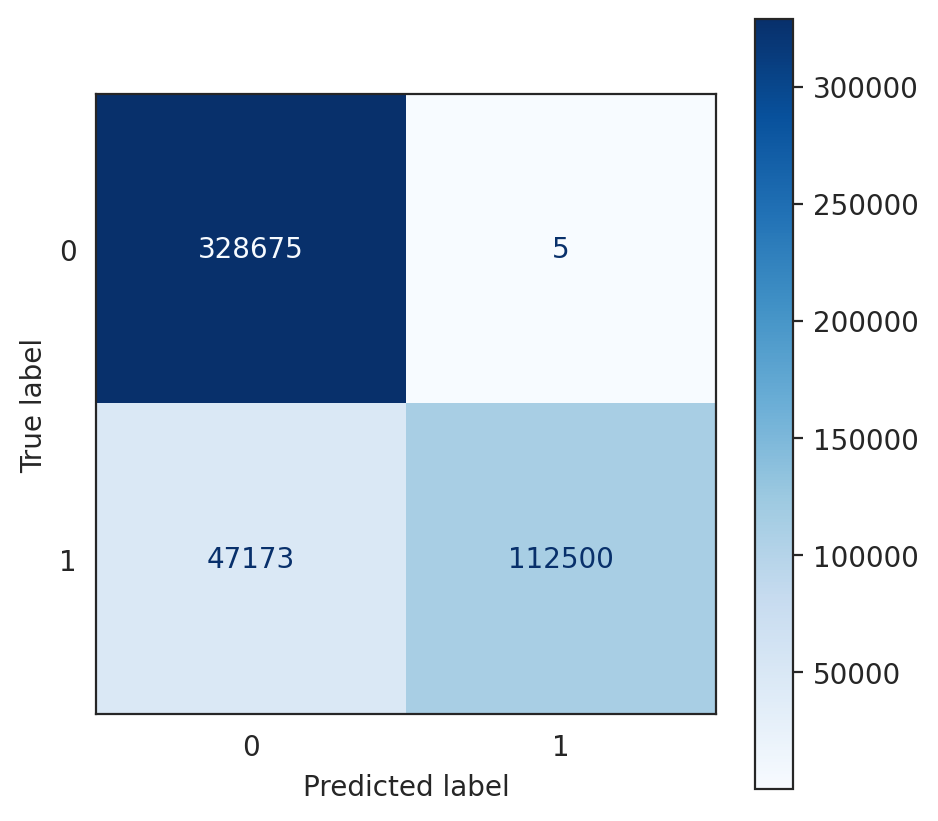

In [123]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(logistic_regression_model, testing, testing_labels, cmap=plt.cm.Blues)  
plt.show()

### Decision Tree

In [127]:
%%time
from sklearn.tree import DecisionTreeClassifier
start = time.time()
decision_tree_model = DecisionTreeClassifier().fit(training,training_labels)
end_train = time.time()
y_predictions = decision_tree_model.predict(testing)
end_predict = time.time()

CPU times: user 22.9 s, sys: 5.37 ms, total: 22.9 s
Wall time: 22.9 s


In [128]:
accuracy = accuracy_score(testing_labels, y_predictions)
recall = recall_score(testing_labels, y_predictions)
precision = precision_score(testing_labels, y_predictions)
f1s = f1_score(testing_labels, y_predictions)
cm = confusion_matrix(testing_labels, y_predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("Accuracy: "+ "{:.3%}".format(accuracy))
print("Recall: "+ "{:.3%}".format(recall))
print("Precision: "+ "{:.3%}".format(precision))
print("F1-Score: "+ "{:.3%}".format(f1s))
print("False positive: "+ "{}".format(FP))
print("False negative: "+ "{}".format(FN))
print("False positive rate: "+ "{:.3%}".format(FPR))
print("False negative rate: "+ "{:.3%}".format(FNR))
print("time to train: "+ "{:.3f}".format(end_train-start)+" s")
print("time to predict: "+"{:.3f}".format(end_predict-end_train)+" s")
print("total: "+"{:.3f}".format(end_predict-start)+" s")
model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s, FPR, FNR, end_train-start, end_predict-end_train, end_predict-start]

Accuracy: 92.265%
Recall: 87.649%
Precision: 88.576%
F1-Score: 88.110%
False positive: 18050
False negative: 19722
False positive rate: 5.492%
False negative rate: 12.351%
time to train: 22.682 s
time to predict: 0.262 s
total: 22.943 s


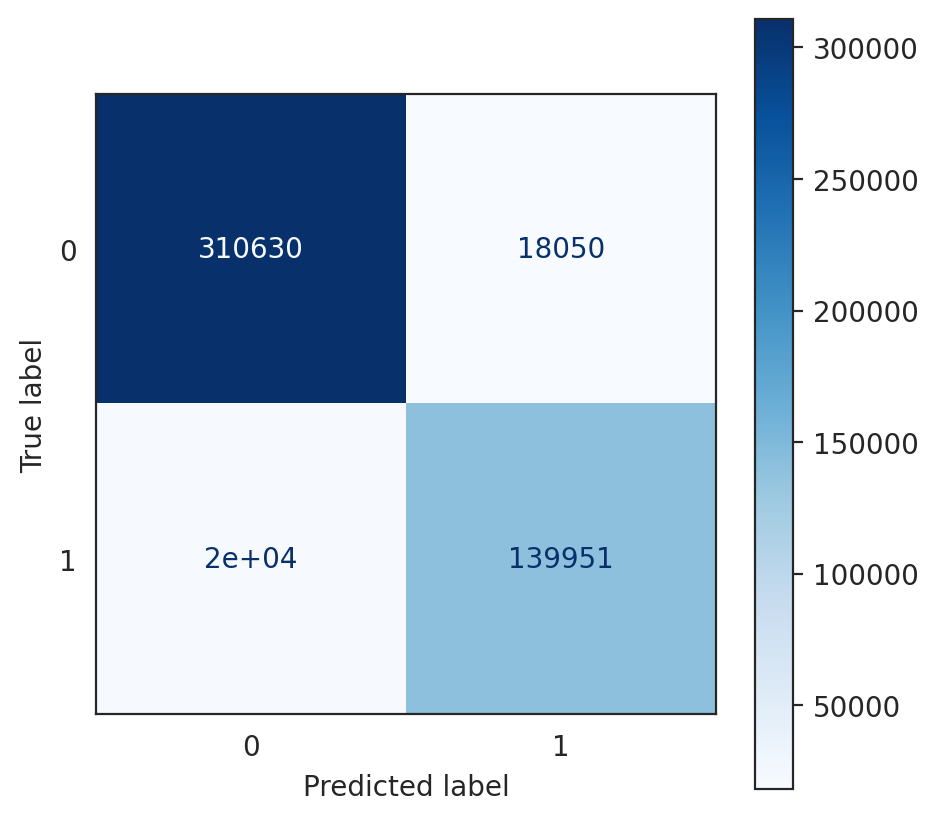

In [129]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(decision_tree_model, testing, testing_labels, cmap=plt.cm.Blues)  
plt.show()

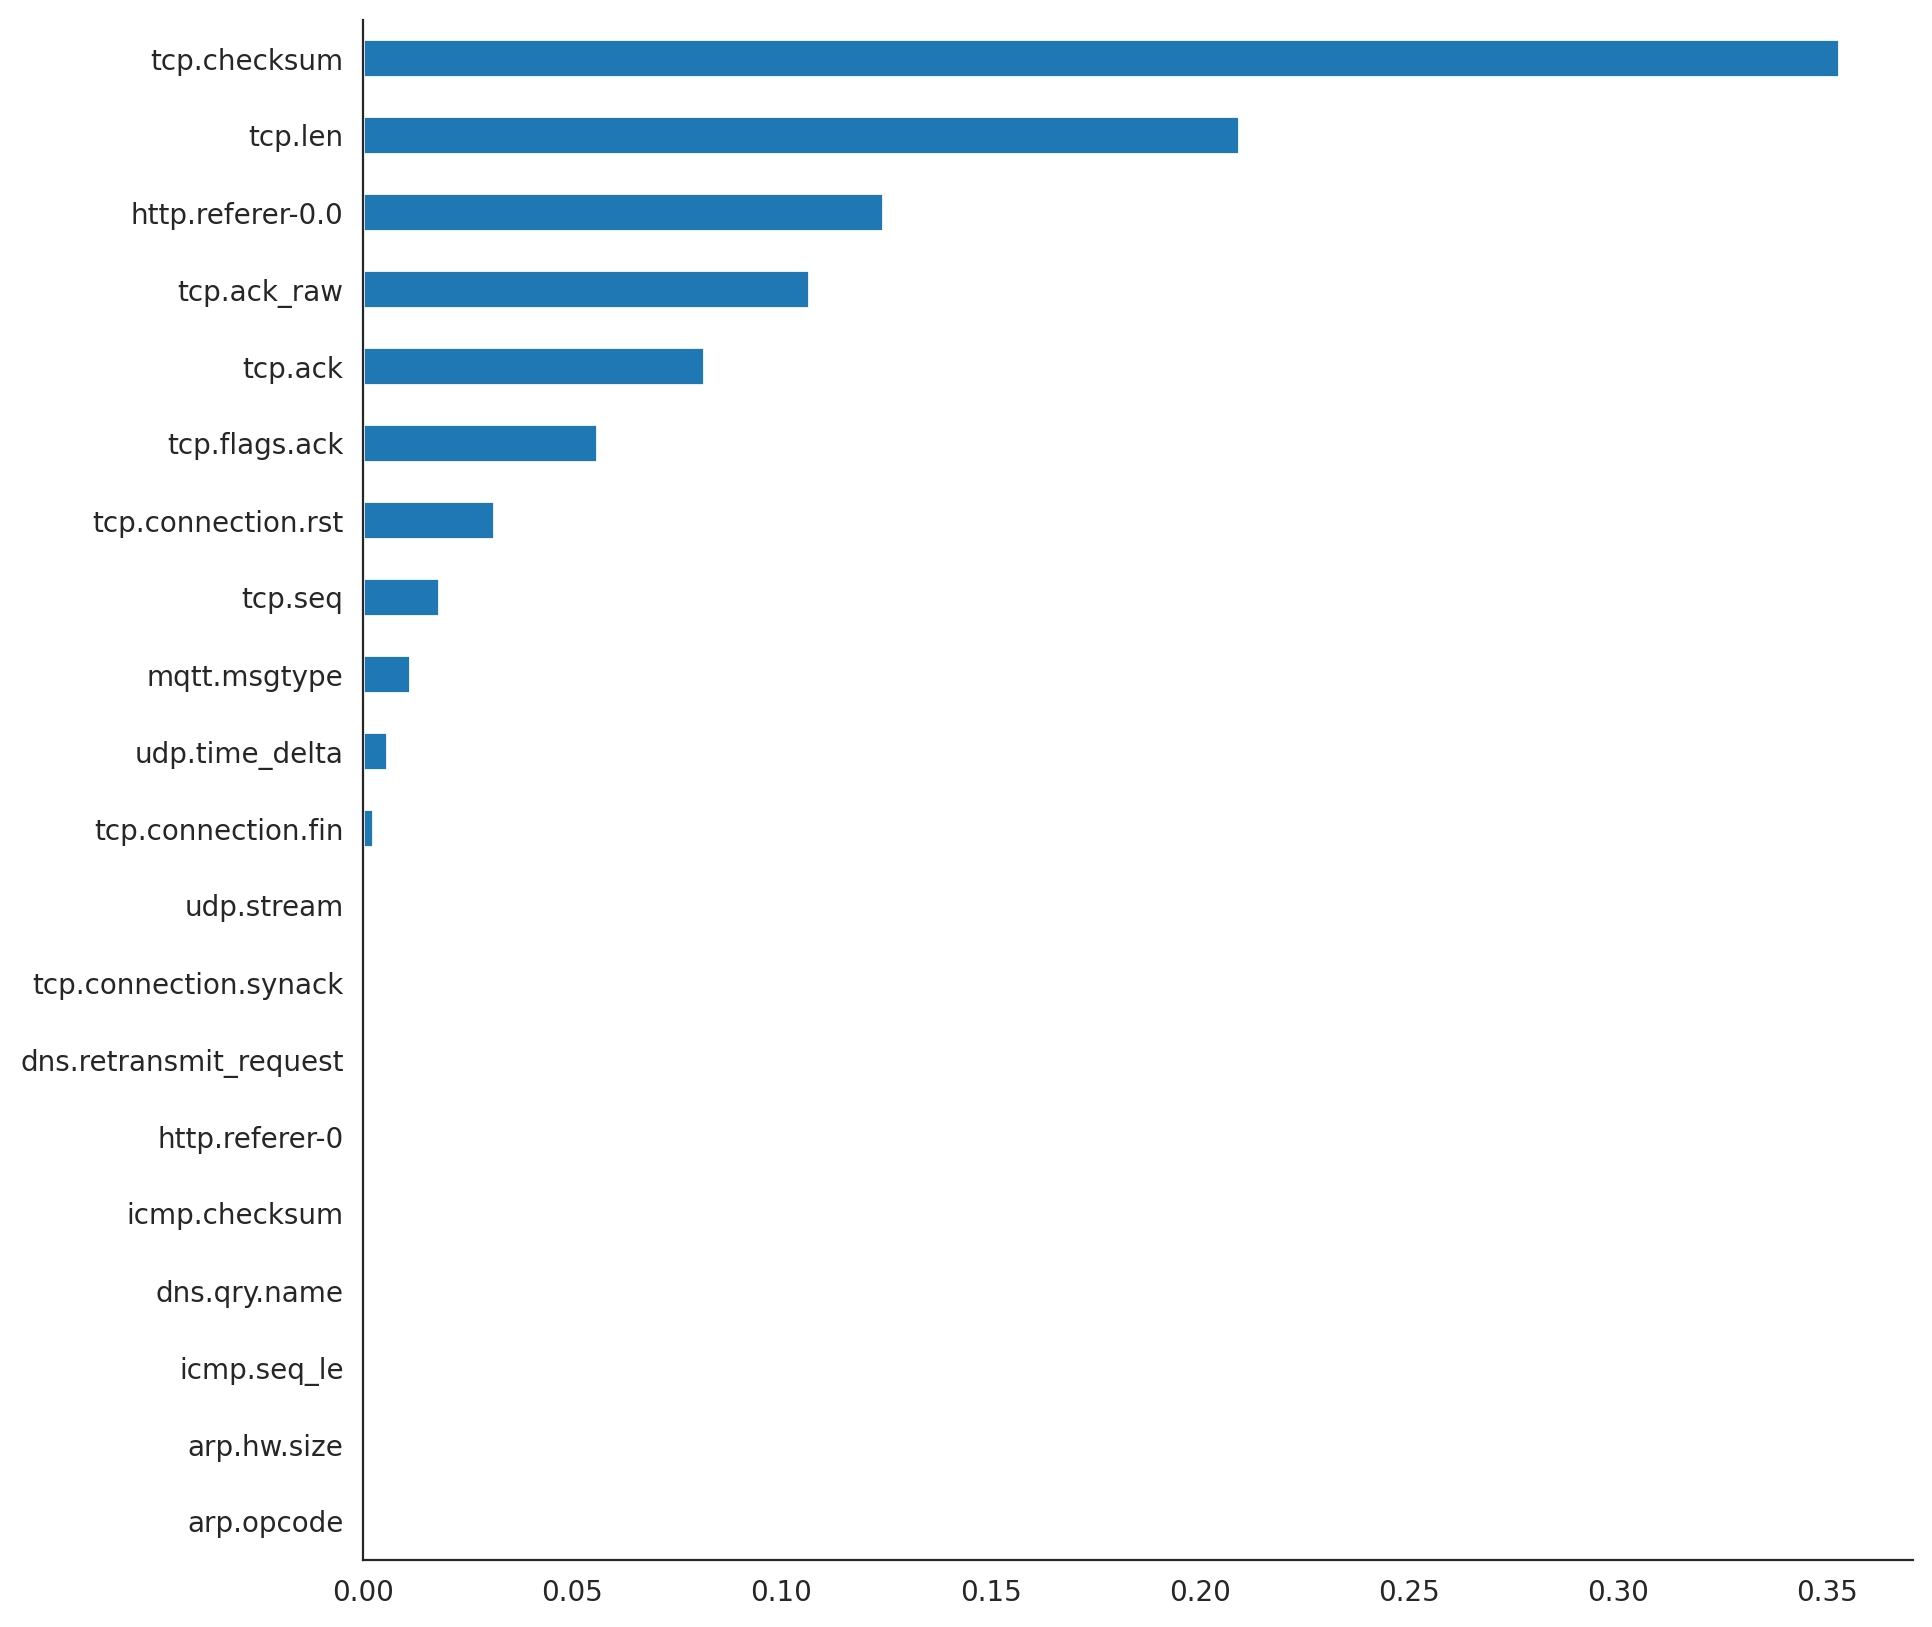

In [130]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(decision_tree_model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

### Random Forest

In [131]:
%%time
from sklearn.ensemble import RandomForestClassifier
start = time.time()
ranfom_forest_model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True).fit(training,training_labels)
end_train = time.time()
y_predictions = ranfom_forest_model.predict(testing) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 6min 34s, sys: 1.79 s, total: 6min 36s
Wall time: 1min 43s


In [132]:
accuracy = accuracy_score(testing_labels, y_predictions)
recall = recall_score(testing_labels, y_predictions)
precision = precision_score(testing_labels, y_predictions)
f1s = f1_score(testing_labels, y_predictions)
cm = confusion_matrix(testing_labels, y_predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("Accuracy: "+ "{:.3%}".format(accuracy))
print("Recall: "+ "{:.3%}".format(recall))
print("Precision: "+ "{:.3%}".format(precision))
print("F1-Score: "+ "{:.3%}".format(f1s))
print("True positive: "+ "{}".format(TP))
print("True negative: "+ "{}".format(TN))
print("False positive: "+ "{}".format(FP))
print("False negative: "+ "{}".format(FN))
print("False positive rate: "+ "{:.3%}".format(FPR))
print("False negative rate: "+ "{:.3%}".format(FNR))
print("time to train: "+ "{:.3f}".format(end_train-start)+" s")
print("time to predict: "+"{:.3f}".format(end_predict-end_train)+" s")
print("total: "+"{:.3f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s, FPR, FNR, end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 93.064%
Recall: 81.410%
Precision: 96.877%
F1-Score: 88.473%
True positive: 129990
True negative: 324489
False positive: 4191
False negative: 29683
False positive rate: 1.275%
False negative rate: 18.590%
time to train: 100.235 s
time to predict: 2.860 s
total: 103.095 s


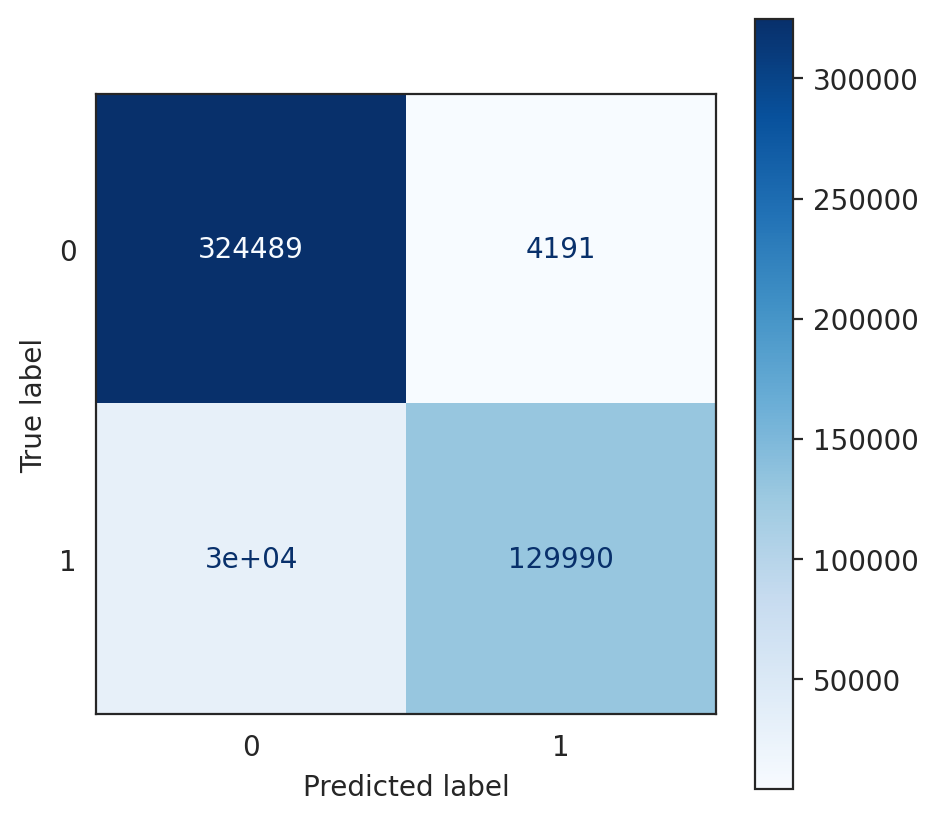

In [133]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(ranfom_forest_model, testing, testing_labels, cmap=plt.cm.Blues)  
plt.show()

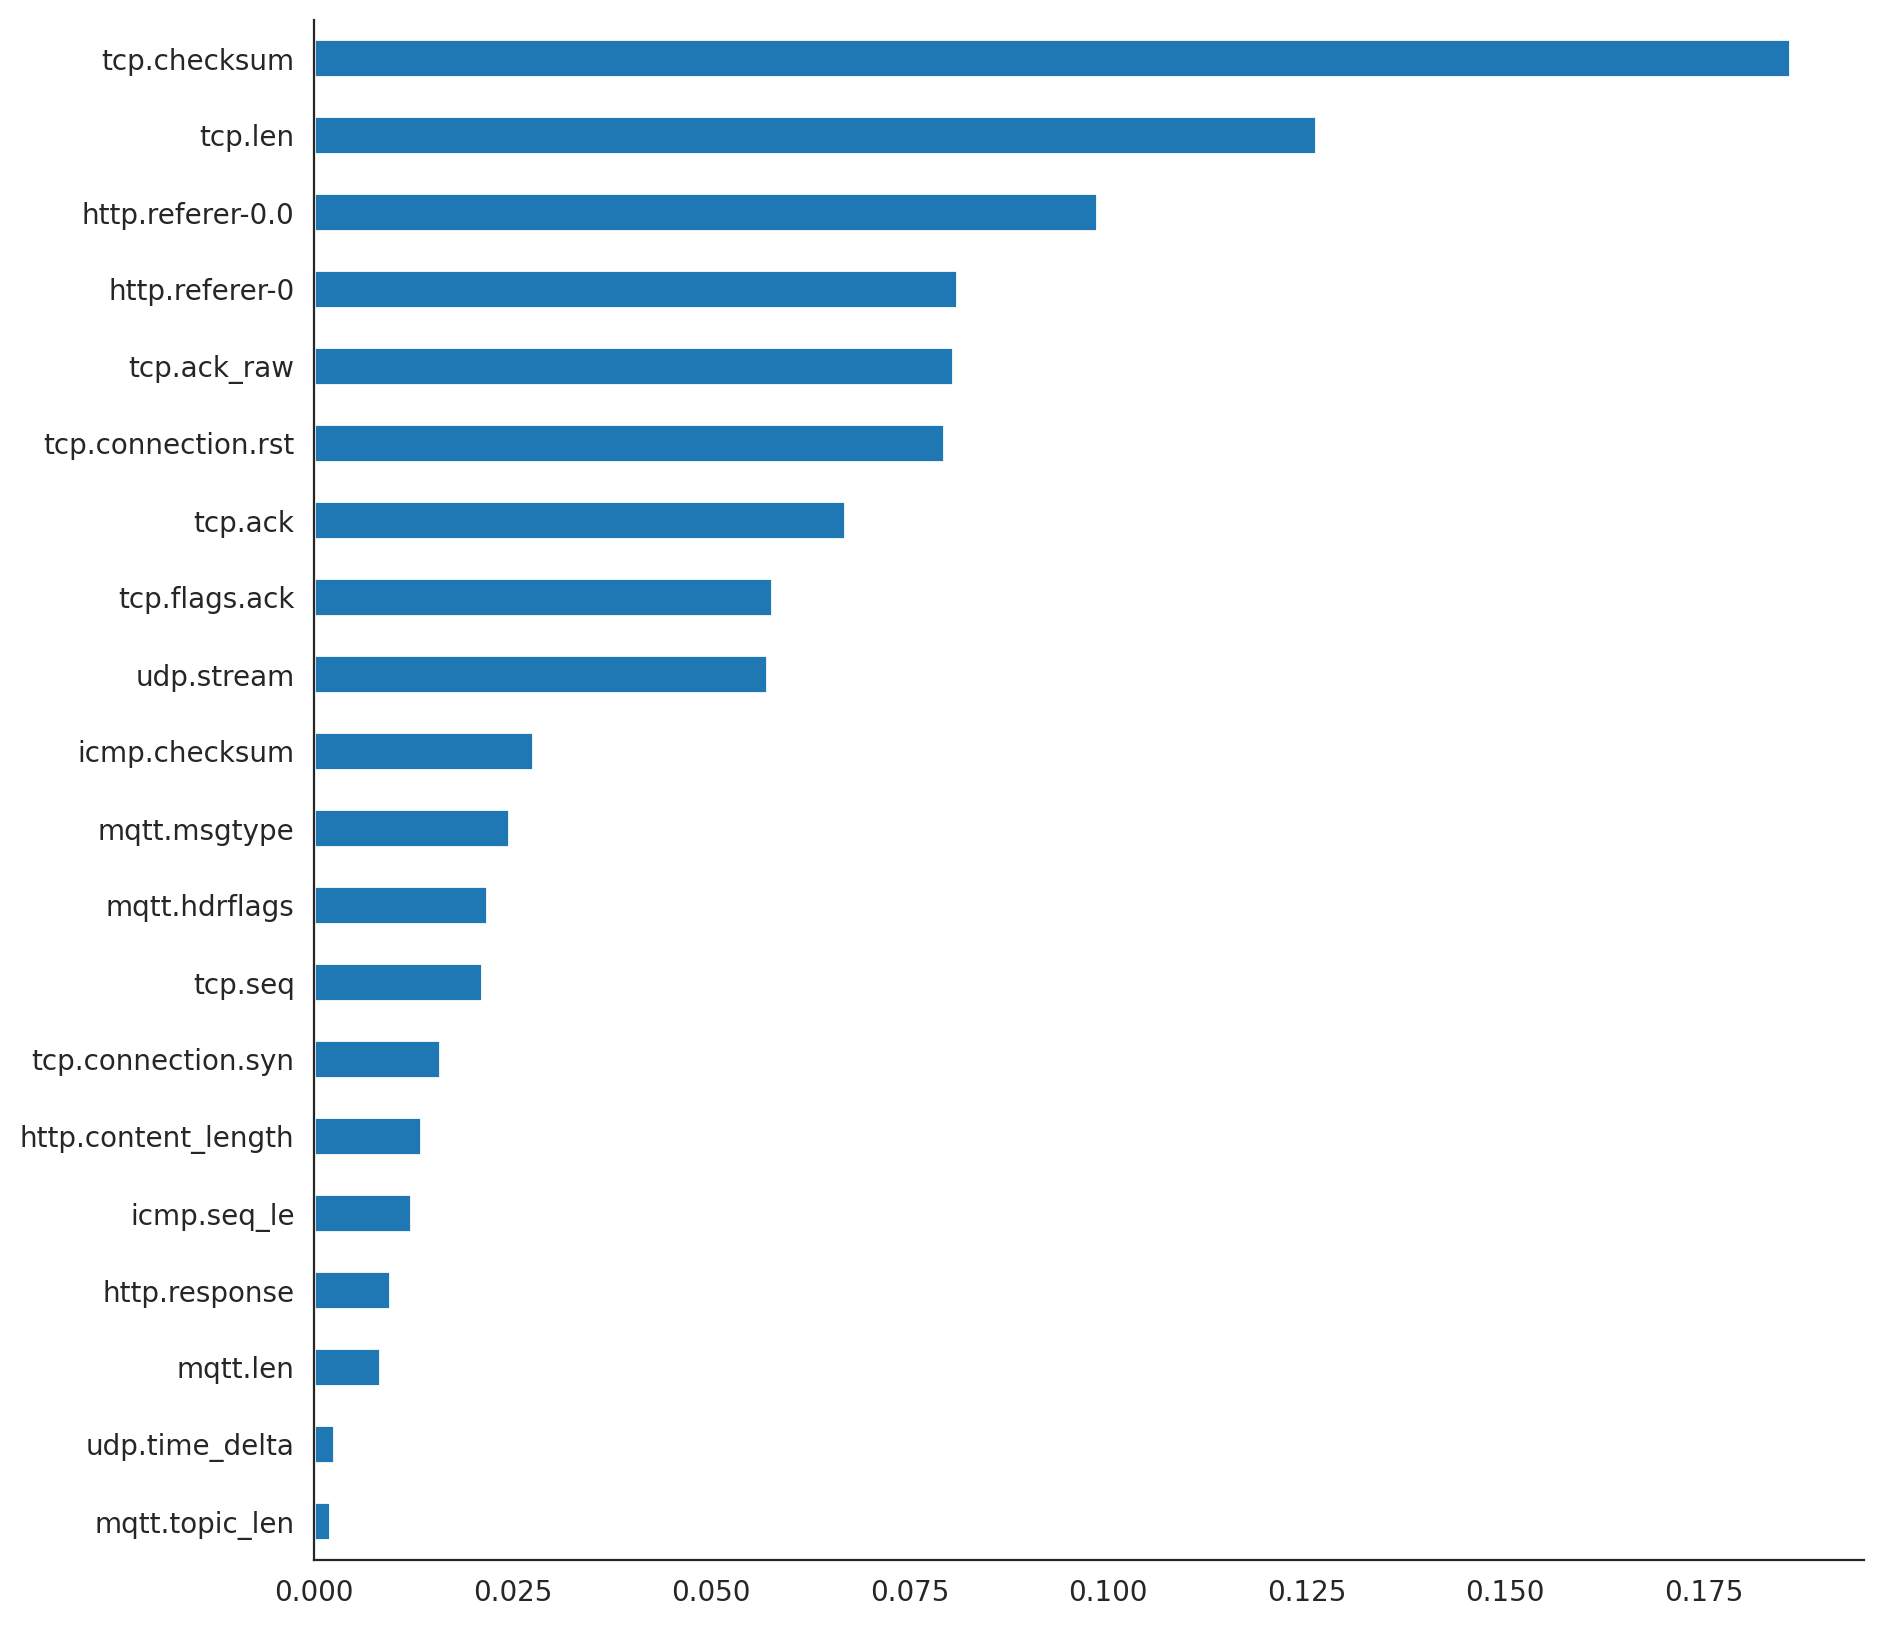

In [134]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(ranfom_forest_model.feature_importances_, index=feature_names)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

### Neural Network MLP

In [135]:
%%time
from sklearn.neural_network import MLPClassifier
start = time.time()
MLP_model = MLPClassifier(hidden_layer_sizes = (20,20,), 
                      activation='relu', 
                      solver='adam',
                      batch_size=2000,
                      verbose=0).fit(training,training_labels)
end_train = time.time()
y_predictions = MLP_model.predict(testing) # These are the predictions from the test data.
end_predict = time.time()


CPU times: user 39min 28s, sys: 25min 46s, total: 1h 5min 15s
Wall time: 16min 51s


In [136]:
accuracy = accuracy_score(testing_labels, y_predictions)
recall = recall_score(testing_labels, y_predictions)
precision = precision_score(testing_labels, y_predictions)
f1s = f1_score(testing_labels, y_predictions)
cm = confusion_matrix(testing_labels, y_predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("Accuracy: "+ "{:.3%}".format(accuracy))
print("Recall: "+ "{:.3%}".format(recall))
print("Precision: "+ "{:.3%}".format(precision))
print("F1-Score: "+ "{:.3%}".format(f1s))
print("False positive: "+ "{}".format(FP))
print("False negative: "+ "{}".format(FN))
print("False positive rate: "+ "{:.3%}".format(FPR))
print("False negative rate: "+ "{:.3%}".format(FNR))
print("time to train: "+ "{:.3f}".format(end_train-start)+" s")
print("time to predict: "+"{:.3f}".format(end_predict-end_train)+" s")
print("total: "+"{:.3f}".format(end_predict-start)+" s")
model_performance.loc['MLP'] = [accuracy, recall, precision, f1s, FPR, FNR, end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 93.189%
Recall: 79.172%
Precision: 99.995%
F1-Score: 88.373%
False positive: 6
False negative: 33257
False positive rate: 0.002%
False negative rate: 20.828%
time to train: 1010.893 s
time to predict: 0.441 s
total: 1011.334 s


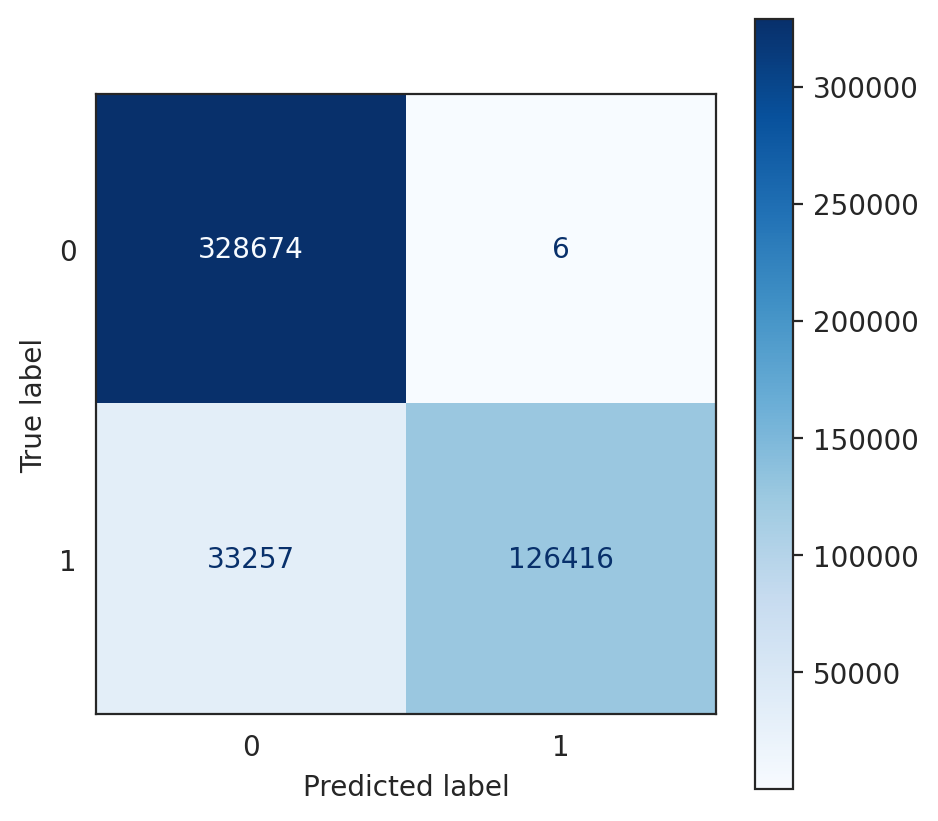

In [137]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(MLP_model, testing, testing_labels, cmap=plt.cm.Blues)  
plt.show()

### AdaBoost

In [138]:
%%time
from sklearn.ensemble import AdaBoostClassifier
start = time.time()
abc_model = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1).fit(training,training_labels)
end_train = time.time()
y_predictions = abc_model.predict(testing) # These are the predictions from the test data.
end_predict = time.time()


CPU times: user 1min 38s, sys: 44.8 ms, total: 1min 38s
Wall time: 1min 38s


In [139]:
accuracy = accuracy_score(testing_labels, y_predictions)
recall = recall_score(testing_labels, y_predictions)
precision = precision_score(testing_labels, y_predictions)
f1s = f1_score(testing_labels, y_predictions)
cm = confusion_matrix(testing_labels, y_predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("Accuracy: "+ "{:.3%}".format(accuracy))
print("Recall: "+ "{:.3%}".format(recall))
print("Precision: "+ "{:.3%}".format(precision))
print("F1-Score: "+ "{:.3%}".format(f1s))
print("False positive: "+ "{}".format(FP))
print("False negative: "+ "{}".format(FN))
print("False positive rate: "+ "{:.3%}".format(FPR))
print("False negative rate: "+ "{:.3%}".format(FNR))
print("time to train: "+ "{:.3f}".format(end_train-start)+" s")
print("time to predict: "+"{:.3f}".format(end_predict-end_train)+" s")
print("total: "+"{:.3f}".format(end_predict-start)+" s")
model_performance.loc['AdaBoostClassifier'] = [accuracy, recall, precision, f1s, FPR, FNR, end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 93.316%
Recall: 79.561%
Precision: 99.995%
F1-Score: 88.616%
False positive: 6
False negative: 32635
False positive rate: 0.002%
False negative rate: 20.439%
time to train: 94.158 s
time to predict: 4.672 s
total: 98.830 s


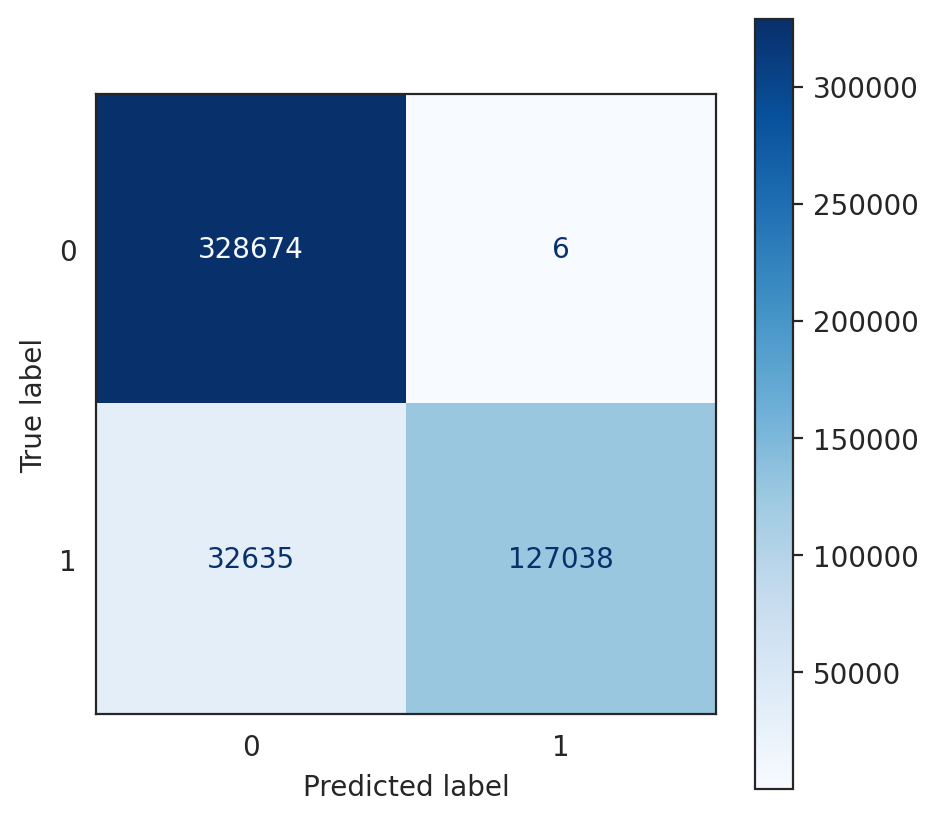

In [140]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(abc_model, testing, testing_labels, cmap=plt.cm.Blues)  
plt.show()

### XGBoost

In [141]:
%%time
import xgboost as xgb
start = time.time()
xgb_model = xgb.XGBClassifier()
xgb_model.fit(training, training_labels)
end_train = time.time()

y_predictions = xgb_model.predict(testing) # These are the predictions from the test data.
end_predict = time.time()


CPU times: user 9min 27s, sys: 789 ms, total: 9min 28s
Wall time: 2min 25s


In [142]:
accuracy = accuracy_score(testing_labels, y_predictions)
recall = recall_score(testing_labels, y_predictions)
precision = precision_score(testing_labels, y_predictions)
f1s = f1_score(testing_labels, y_predictions)
cm = confusion_matrix(testing_labels, y_predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("Accuracy: "+ "{:.3%}".format(accuracy))
print("Recall: "+ "{:.3%}".format(recall))
print("Precision: "+ "{:.3%}".format(precision))
print("F1-Score: "+ "{:.3%}".format(f1s))
print("False positive: "+ "{}".format(FP))
print("False negative: "+ "{}".format(FN))
print("False positive rate: "+ "{:.3%}".format(FPR))
print("False negative rate: "+ "{:.3%}".format(FNR))
print("time to train: "+ "{:.3f}".format(end_train-start)+" s")
print("time to predict: "+"{:.3f}".format(end_predict-end_train)+" s")
print("total: "+"{:.3f}".format(end_predict-start)+" s")
model_performance.loc['XGBoost'] = [accuracy, recall, precision, f1s, FPR, FNR, end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 97.718%
Recall: 93.026%
Precision: 99.995%
F1-Score: 96.384%
False positive: 8
False negative: 11136
False positive rate: 0.002%
False negative rate: 6.974%
time to train: 145.101 s
time to predict: 0.643 s
total: 145.744 s


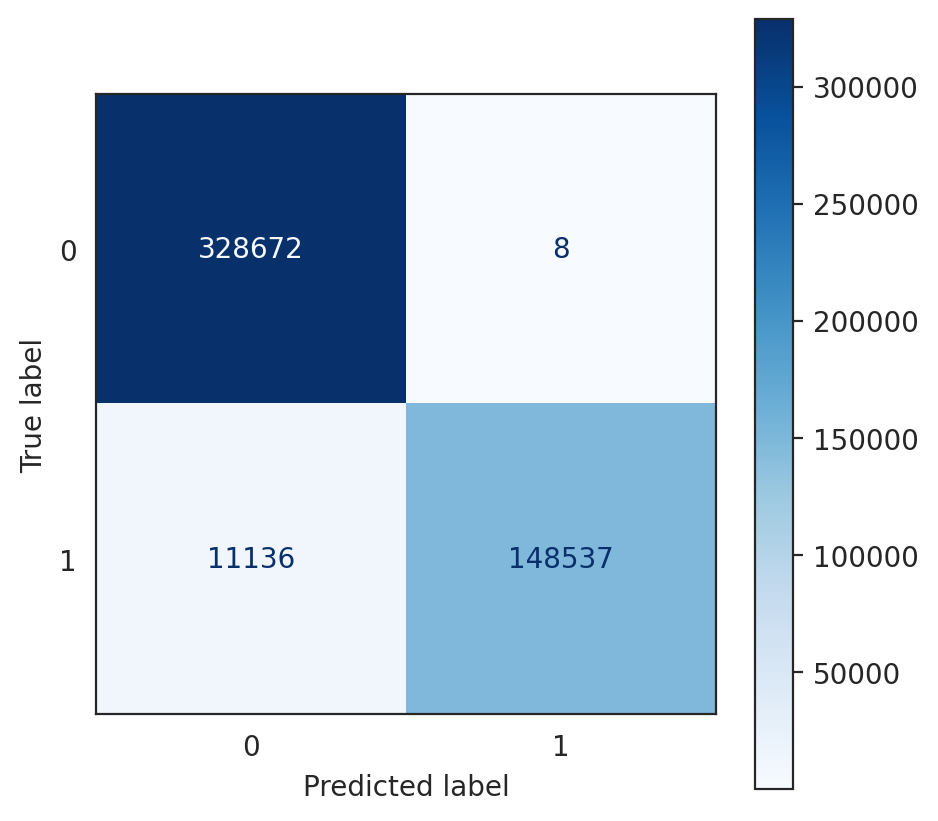

In [143]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(xgb_model, testing, testing_labels, cmap=plt.cm.Blues)  
plt.show()

### naive bayes

In [150]:
%%time
from sklearn.naive_bayes import GaussianNB
start = time.time()
gnb_model = GaussianNB().fit(training,training_labels)
end_train = time.time()
y_predictions = gnb_model.predict(testing) # These are the predictions from the test data.
end_predict = time.time()


CPU times: user 1.17 s, sys: 77.5 ms, total: 1.24 s
Wall time: 1.24 s


In [151]:
accuracy = accuracy_score(testing_labels, y_predictions)
recall = recall_score(testing_labels, y_predictions)
precision = precision_score(testing_labels, y_predictions)
f1s = f1_score(testing_labels, y_predictions)
cm = confusion_matrix(testing_labels, y_predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("Accuracy: "+ "{:.3%}".format(accuracy))
print("Recall: "+ "{:.3%}".format(recall))
print("Precision: "+ "{:.3%}".format(precision))
print("F1-Score: "+ "{:.3%}".format(f1s))
print("False positive: "+ "{}".format(FP))
print("False negative: "+ "{}".format(FN))
print("False positive rate: "+ "{:.3%}".format(FPR))
print("False negative rate: "+ "{:.3%}".format(FNR))
print("time to train: "+ "{:.3f}".format(end_train-start)+" s")
print("time to predict: "+"{:.3f}".format(end_predict-end_train)+" s")
print("total: "+"{:.3f}".format(end_predict-start)+" s")
model_performance.loc['GaussianNB'] = [accuracy, recall, precision, f1s, FPR, FNR, end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 53.248%
Recall: 100.000%
Precision: 41.154%
F1-Score: 58.311%
False positive: 228316
False negative: 0
False positive rate: 69.465%
False negative rate: 0.000%
time to train: 0.997 s
time to predict: 0.246 s
total: 1.244 s


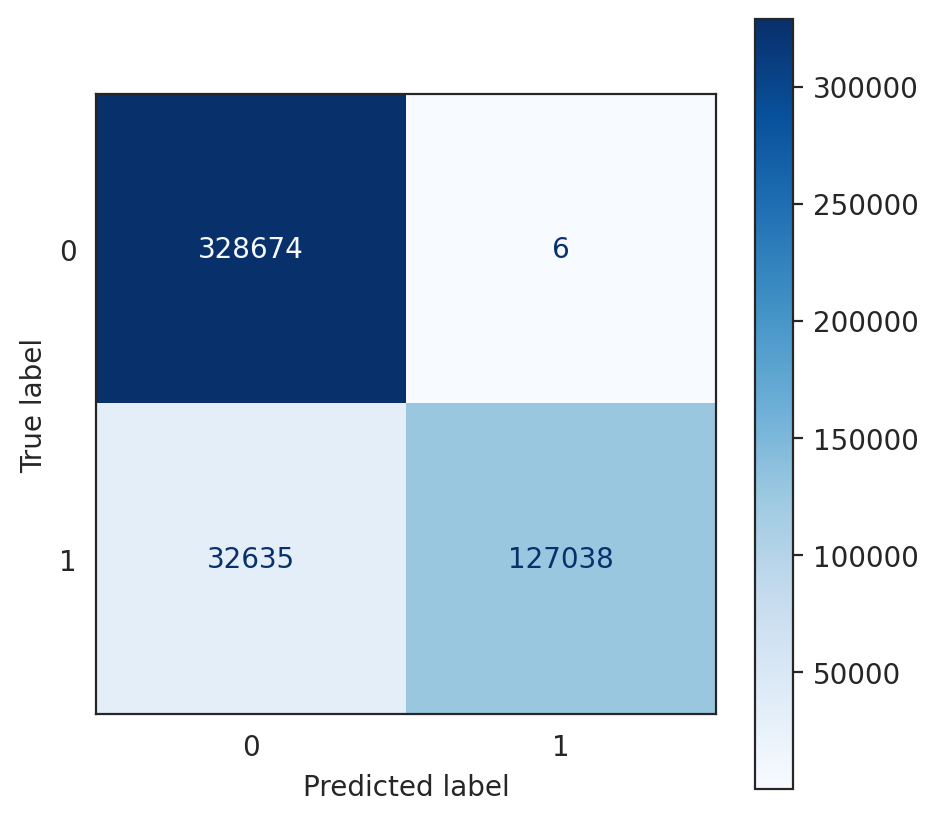

In [152]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(abc_model, testing, testing_labels, cmap=plt.cm.Blues)  
plt.show()

# Evaluation

In [153]:
model_performance.fillna(0.9,inplace=True)
if with_network_features:
    print("Enhanced with Complex Network Features")
else:
    print("No Complex Network Features")
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.3%}',
                                                                     'Recall': '{:.3%}',
                                                                     'Precision': '{:.3%}',
                                                                     'F1-Score': '{:.3%}',
                                                                     'FPR': '{:.3%}',
                                                                     'FNR': '{:.3%}',
                                                                     'time to train':'{:.3f}',
                                                                     'time to predict':'{:.3f}',
                                                                     'total time':'{:.3f}',
                                                                     })

No Complex Network Features


,Accuracy,Recall,Precision,F1-Score,FPR,FNR,time to train,time to predict,total time
Logistic,90.339%,70.456%,99.996%,82.666%,0.002%,29.544%,26.030,0.042,26.072
Decision Tree,92.265%,87.649%,88.576%,88.110%,5.492%,12.351%,22.682,0.262,22.943
Random Forest,93.064%,81.410%,96.877%,88.473%,1.275%,18.590%,100.235,2.860,103.095
MLP,93.189%,79.172%,99.995%,88.373%,0.002%,20.828%,1010.893,0.441,1011.334
AdaBoostClassifier,93.316%,79.561%,99.995%,88.616%,0.002%,20.439%,94.158,4.672,98.830
XGBoost,97.718%,93.026%,99.995%,96.384%,0.002%,6.974%,145.101,0.643,145.744
GaussianNB,53.248%,100.000%,41.154%,58.311%,69.465%,0.000%,0.997,0.246,1.244
